# 7 Hyperparameter tuning
This notebook contains a summary of qualitative and quantitative comparison of hyperparameters. 

### Hyperparameters
* `window` refers to the window size of the word2vec model.
* `length` refers to the length of random walks. 
* `p` and `q` control how quickly the random walk explores outside the neighborhood of a start node. 
    * `q` (in-out parameter) differentiates between "inward" and "outward" nodes
        * If `q` > 1, the random walk is biased to stay close to the start node.
        * If `q` < 1, the random walk is encouraged to explore outside the local neighborhood.
    * `p` (return parameter) controls the likelihood of revisiting a node.
        * If `p` is high (`p` > max(q,1)), the random walk is less likely to sample already-visited nodes in the following steps.
        * If `p` is low (`p` < min(q, 1)), the random walk stays close to the start node.
        
### Contents
1. Qualitative comparison for `window`
2. Hyperparameter tuning (quantiative analysis) for `p`, `q`, `length`
3. Qualitative comparison of different `p`, `q` values.

### Summary of findings
* By `window`: 
    * The impact of parameter `window` is most noticeable when we compare recommendation outputs for composers.
    * Model with a small window size (5) places the vectors so that artists who have strong collaboration with a particular composer have similar vectors. 
    * Model with a larger window size (20) results in an embedding in which composers are embedded close to each other. 
    * This is consistent with what one would expect from word2vec embedding on text data - Using a large window tends to incorporate the topical/ domain similarity of words, whereas using a smaller window tends to focus on the more local, syntactic structure of the text.
* By `length`: Both related-artist F1 and collaborator F1 scores are higher for models with `length` > 10.
* By `p`, `q`: 
    * Quantitative comparison
        * The collaborator F1 score is better for lower values of `q`, but the improvement was miniscule. I thus decided to choose `p` and `q` through a qualitative comparison of the resulting recommendation systems.
    * Qualitative comparison
        * Note that there are different types of artists, such as individual performers, orchestras, and composers.
        * One may consider building separate recommenders (with different `p` and `q`) for different types of artists.
        * I focused my recommendation system on the individual performers. I chose the following parameters for my final model: `p` = 0.2, `q`= 4, `length` = 20, `window` = 5. (Note that the selection of `p` and `q` is based on my personal preference.)
        
### Challenge & future directions
* The hyperparameter tuning process was difficult because we do not have a well-defined metric to optimize for. 
* Towards the end of this project, I came across this <a href="https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge">Spotify playlist dataset</a>. In future versions, I may use this dataset to design my own evaluation metric and re-run the hyperparameter tuning process.

In [ ]:
import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', None)
import pickle
plt.style.use("seaborn")

from gensim.models import Word2Vec, KeyedVectors
from musicians import *
from statistics import median

In [2]:
# load ID_name dict
with open('graph_80000/ID_name.pkl', 'rb') as f:
    ID_name = pickle.load(f)
    
with open('graph_80000/name_ID.pkl', 'rb') as f:
    name_ID = pickle.load(f)

# 1 Qualitative comparison of `window`

* I built two recommenders whose Word2Vec were trained with window sizes of 5 and 20. I then compared the recommendation outputs for various artists. 
* The impact of parameter `window` is most noticeable when we compare recommendation outputs for composers.
* This section shows an example comparison of the recommendations for composers. 
* The random walk parameters were fixed at `p` = 1, `q` = 1, and `length` = 20.

In [3]:
df = pd.read_csv("graph_80000/hyperparameter_tuning/window_comparison.csv")
df

,artist,similar artists - window size 5,similar artists - window size 20
0,Ludwig van Beethoven,"Florian Paul, Peter Popa, Johannes Brahms, Vincent Lièvre-Picard, Dania El Zein, Levente Filip, Juliette Allen, Andrea Musto, The Key Ensemble, Mary Kathryn Van Osdale, Robert Schumann, Zsolt Szatmári, Sándor Berki, Gyözö Máthé, Libero Lana, Kristin Sampson, Jean-François Rouchon, Júlia Gábor, György Éder, Young New Yorkers' Chorus","Johannes Brahms, Robert Schumann, Franz Schubert, Frédéric Chopin, Susanna Eyton-Jones, Young New Yorkers' Chorus, Central City Choir, Wolfgang Amadeus Mozart, Júlia Gábor, New York City Master Chorale, New Amsterdam Singers, Jan Wilson, Peter Popa, West Point Glee Club, James Archie Worley, Johanna Lehesvuori, Zágrábi Filharmonikus, Brearley Singers, Franz Liszt, Florian Paul"
1,Johannes Brahms,"Robert Schumann, Ludwig van Beethoven, Franz Schubert, Paul Roczek, Monika Henschel, Christian Kohn, Giselher Klebe, Dankwart Gahl, Irmgard Gahl, Karl Doktor, Peter Katt, Saiko Sasaki, Jürgen Uhde, Kunio Tsuchiya, Silke-Thora Matthies, Wilfred Tachezi, Alfred Malecek, Geoffroy Couteau, Lisa Carlyna Zumpano, Antonín Dvořák","Robert Schumann, Ludwig van Beethoven, Franz Schubert, Giselher Klebe, Gustav Lange, Frédéric Chopin, Antonín Dvořák, Gustav Uwe Jenner, Wolfgang Amadeus Mozart, Felix Mendelssohn, Franz Liszt, Max Bruch, Sergei Rachmaninoff, Pyotr Ilyich Tchaikovsky, Béla Bartók, Maurice Ravel, Edvard Grieg, David Wolfsthal, Tekla Bądarzewska-Baranowska, Osmo Tapio Räihälä"


### Findings
* The most noticeable difference occurs for composers. 
* Embedding with a small window size (5) places the final vectors so that artists who have strong collaboration with a particular composer have similar vectors. 
* Training with a larger window size (20) results in an embedding in which composers are embedded close to each other. 
* This is consistent with what one would expect from word2vec embedding on text data - Using a large window tend to incorporate the topical/ domain similarity of words, whereas using a smaller window tend to focus on the more local, syntactic structure of the text.


# 2 Hyperparameter tuning for `p`, `q`, `length` 

* I used cloud computing (GCP) to (1) generate the random walks and (2) train the word2vec model. See `hyperparameter_tuning.py` for script.
* For computation speed reasons, I generated random walks from a smaller graph which consists of artists with 11 or more collaborators. 
* For each collection of hyperparameters, I examined their training loss to identify the optimal number of epochs.
* I then created the recommendation system using the selected model and evaluated the performance using the related-artist F1 and collaborator-F1 scores. 

## 2(a) Create a smaller graph
* Smaller graph consists of artists that have 11 or more collaborators.

In [4]:
### load data
Gix = ig.read('graph_80000/graph.gml', format="gml")

# select minimum degree of nodes to include
min_degree = 10
delete_idx = [v.index for v in Gix.vs if v.degree() <= min_degree]
print("number of nodes to remove: ", len(delete_idx))

# delete nodes with low degree
Gix.delete_vertices(delete_idx)
print("Remaining number nodes: ", len(Gix.vs))

#Gix.save("graph_80000/graph_min_degree_10.gml")

number of nodes to remove:  134033
Remaining number nodes:  54261


Run the script `hyperparameter_tuning.py`. 
For speed reasons, I used Google Cloud 

##  2(b) Analyze hyperparameter tuning

The following cells summarize how I performed the hyperparameter tuning. Due to storage limits, I decided not to share all the models that were saved during the tuning process.


For each iteration (parameters), plot the training loss from Word2vec training and determine the optimal epoch.

In [4]:
# load train loss
train_loss = dict()
for i in range(3):
    with open("graph_80000/hyperparameter_tuning/sample_process/train_loss_" + str(i) +".pkl", "rb") as f:
        loss = pickle.load(f)
    train_loss[i] = loss

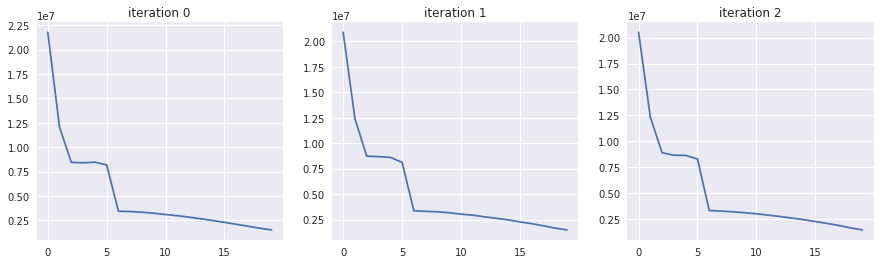

In [5]:
# example process for selecting epoch 
fig, ax = plt.subplots(ncols = 3, figsize = (15, 4))
for i in range(3):
    ax[i].plot(train_loss[i])
    ax[i].set_title("iteration " + str(i))

plt.show()

Based on the training losses, we'll select the model after epoch 6 for the three iterations shown.
* Note that it's impossible to create a CV set and monitor the CV loss when training a self-supervised model like word2vec. 
* In order to prevent 'overfitting', I choose the optimal number of epochs to be the point at which training loss stops improving.

For each iteration, select epoch using above method. I then evaluated the models using the related-artists F1 score and collaborators-F1 score as illustrated in notebook `6_evaluation.ipynb`.

Due to large size of the models, I did not include the code for computing the evaluation metric from the various models. 

The related-artists F1 scores were 0 for all models. The collaborators-F1 scores are illustrated in the following plot. 

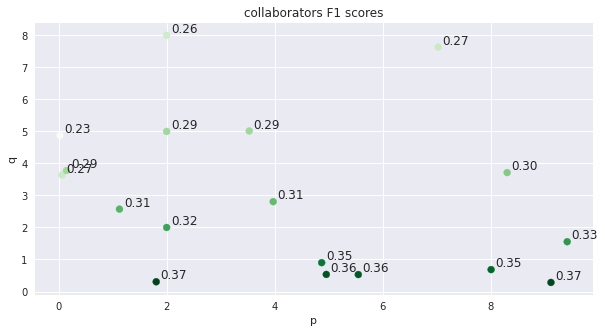

In [6]:
# load the different hyperparameters used
directory = "graph_80000/hyperparameter_tuning/sample_process"

params = dict()
for i in range(18):
    with open(directory + "/iteration_"+str(i)+"_parameters.pkl", "rb") as f:
        param_i = pickle.load(f)
        params[i] = param_i

# load evaluation of various models
with open("graph_80000/hyperparameter_tuning/evaluation_related_artist.pkl", "rb") as f:
    evaluation_related = pickle.load(f)
with open("graph_80000/hyperparameter_tuning/evaluation_collaborators.pkl", "rb") as f:
    evaluation_collaborators = pickle.load(f)

# get list
related = [evaluation_related[i] for i in range(len(evaluation_related))]
collab = [evaluation_collaborators[i] for i in range(len(evaluation_collaborators))]
n = len(related)

# load parameters
params = dict()
for i in range(n):
    # load hyperparameters
    with open(directory + "/iteration_"+str(i)+"_parameters.pkl", "rb") as f:
        param_i = pickle.load(f)
        params[i] = param_i

# get list of p and q
p = [params[i]['p'] for i in range(n)]
q = [params[i]['q'] for i in range(n)]

# colors
collab_scaled =  [(x - min(collab))/(max(collab)- min(collab)) for x in collab]
collab_colors = plt.cm.Greens(collab_scaled)

fig, ax = plt.subplots(figsize = (10, 5))

# plot neighbors - F1 scores
ax.scatter(p, q, c = collab_colors)
for i in range(18):
    ax.text(p[i] + 0.08, q[i] + 0.08, "{:.2f}".format(collab[i]), fontsize = 12)
ax.set_xlabel("p")
ax.set_ylabel("q")
ax.set_title("collaborators F1 scores")
plt.show()

## Overall comparison
* The related-artists F1 scores were zeros for all parameters.
* For the collaborator F1 scores, the performance seemed to depend on the values of `q` and less on the values of `p`. The performance was better for smaller values of `q`. That is, when we find the model with small `q` values, our model does a better job a predicting the immediate collaborators of artists.
* Note that the improvement in F1 score is very small. I thus decided to choose the optimal `p` and `q` via a qualitative comparison of the resulting recommendation systems.

# 3. Qualitative comparison of `p` and `q`


* This section shows an example qualitative comparison of two models with different `p` and `q` values.
    * model_1: p = 0.1, q = 10 (low p high q)
    * model_2: p = 10, q = 0.1 (high p low q)
* Other parameters were fixed at `length` = 20, `window` = 20.
* For the two recommenders, I compared the recommendation output for selected artists. In particular, I compared the models for performers, orchestras, and composers. 

<b> Comparison of performers </b>
* The difference in embedding for the performers isn't drastic, but I had a slight preference for the embedding of model 1. 
* For example, I liked that artist Emil Gilels is embedded close to Leonid Kogan, Sviatoslav Richter, Mstislav Rostropovich, and Van Cliburn. 
* Overall, the embedding via model 1 had more artists that I consider as 'close' than model 2.


In [7]:
df = pd.read_csv("graph_80000/hyperparameter_tuning/pq_performers.csv")
df

,artist,similar artists - model 1: low p high q,similar artists - model 2: high p low q
0,Emil Gilels,"Leonid Kogan, Daniil Shafran, Yakov Zak, Emil Giles, Yakov Flier, Sviatoslav Richter, Kirill Kondrashin, Julius Katchen, Mstislav Rostropovich, Grigory Ginzburg, Anatol Ugorski, Ania Dorfmann, Dino Ciani, Karl Eliasberg, Hisako Kawamura, Van Cliburn, Elena Gilels, USSR State Symphony Orchestra, Anton Ginsburg, Oscar Levant","Elena Gilels, Vladimir Bunin, Yakov Zak, Yakov Flier, Leonid Kogan, Anton Ginsburg, USSR State Symphony Orchestra, Yuri Mouravlev, Vladimir Selivokhin, Nikolai Anosov, Grigory Ginzburg, Nikolai Kharkovsky, Maria Grinberg, Moscow Large Symphony Orchestra, Guenadi Rojdestvenski, Daniil Shafran, Karl Eliasberg, Ussr State Radio Orchestra, Emil Giles, Moscow Radio Orchestra"
1,Mitsuko Uchida,"Hiroko Ehara, Quartetto Bernini, Benjamin Hochman, Murray Perahia, German Wind Soloists, Grumiaux Trio, Peter Frankl, Charles Rosen, Frank Peter Zimmermann, Stuttgart Piano Trio, Christian Zacharias, Quartetto Italiano, Peter Aronsky, Claudio Abbado/Emmanuel Pahud/Berliner Philharmoniker, Sudwestfunk Symphony Orchestra Baden-Baden, Carl Seemann, Mozarteum Quartet Salzburg, Signum Quartet, Diastema Saxophone Quartet, Suske Quartett","Benjamin Hochman, Lisa Wellbaum, Ladies of the Cleveland Orchestra Chorus, Jakob Gimpel, Pierre-Laurent Aimard, Dieter Zechlin, Albert Ferber, Jeffrey Tate, Murray Perahia, Yuko Batik, Charles Rosen, Catherine Collard, Misha Goldstein, Seong-Jin Cho, Radu Lupu, Pinchas Zuckerman, Franklin Cohen, Peter Serkin, Dmitri Bashkirov, David Pittmann-Jennings"
2,Mstislav Rostropovich,"Emil Giles, Galina Vishnevskaya, Katherine Austin, Emil Gilels, Peter Howard, Orchestra of the Collegium Musicum, Lazar Dvoskin, Alexandre Stein, Borodin Quartet, Alexei Zybtsev, Leonid Kogan, Santiago Canon Valencia, Виктор Дубровский, Maxim Vengerov, Vladimir Feltsman, Sviatoslav Richter, Layton James, Дмитрий Шостакович, Симфонический оркестр Московской филармонии, National Symphony Orchestra Washington","Galina Vishnevskaya, Морис Равель, Alexander Dedyukhin, Tchaikovsky Choir, Антонин Дворжак, Boris Simsky, Dmitri Shebalin, Boris Khaikine, Vyacheslav Polozov, Stefan Szkafarowsky, Choeur Tchaikovsky, Alexandre Stein, Galina Gregorieva, Misha Raitzin, Russian Symphony Orchestra, Gregory Stolyarov, Роберт Шуман, Клод Дебюсси, Mark Reshetin, Mstislav Rostopovich"
3,Daniil Trifonov,"Alexandre Dossin, Igor Tchetuev, Haochen Zhang, Matthew Cameron, Olga Kern, Victor Merzhanov, Daniel Pollack, Rafael Orozco, Yulianna Avdeeva, Vladimir Sofronitsky, Olga Scheps, Adriel Gomez-Mansur, Denis Matsuev, Nina Kavtaradze, Mikhail Pletnev, Sophia Agranovich, Boris Bloch, Simon Barere, Raymond Trouard, Alexander Kobrin","Agustin Anievas, Yoram Ish-Hurwitz, Aldona Dvarionaité, Adriel Gomez-Mansur, Hwayoon Lee, Olga Kern, Alexandrina Pendachanska, Dmitry Shishkin, Rafael Orozco, Anna Kravtchenko, Yulianna Avdeeva, Dudana Mazmanishvili, Seong-Jin Cho, Soyeon Kate Lee, Simon Barere, Georgijs Osokins, Daniel Pollack, Mikhail Rudy, Alexandre Dossin, Luxembourg Philharmonia"
4,Evgeny Kissin,"Hiroshi Oshima, Kristina Clemenz, Vladimir Sofronitsky, Ivo Pogorelich, Misha Goldstein, Eva Sukova, Eugene Mursky, Shura Cherkassky, Emerson String Quartet, Sophia Agranovich, Vladimir Feltsman, Moscow Philharmonic Orchestra, Byron Janis, Anatol Ugorski, Rudolf Kerer, Yu Kosuge, Calm Classic, Camille Capasso, Alexandre Dossin, Maurizio Pollini","Kristina Clemenz, Hiroshi Oshima, Friedrich Molsberger, Camille Capasso, Alexander Ghindin, Moscow Philharmonic State Symphony Orchestra, Arcadi Volodos, Yakov Flier, Araksia Davtyan, Yelena Adjemova, Oxana Yablonskaya, Vladimir Sofronitsky, Dmitri Kortchak, Andrey Azovsky, Sveshnikov Boys and Men's Choir, Nikita Mndoyants, Vladimir Krainev, Nikolai Petrov, Israela Margalit, Oleg Yanchenko"
5,Yuja Wang,"Gustavo Dudamel, Los Angeles Philharmonic, Vadym Kholodenko, Lionel Bringuier, Ivo Pogorelich, Norbert Kirchman

<b> Comparison of orchestras </b>
* For orchestras, artists with close embeddings tend to be other orchestras, conductors, members of the orchestras, and other soloists. 
* Again, the difference isn't drastic, but model 1 tends to embed other orchestras and group performers closer than individual artists. 

In [8]:
df = pd.read_csv("graph_80000/hyperparameter_tuning/pq_orchestras.csv")
df

,artist,similar artists - model 1: low p high q,similar artists - model 2: high p low q
0,Berliner Philharmoniker,"Alain Hitier, Mechthild Gessendorf, Wiener Philharmoniker, Berliner Philharmoniker Orchestra, Julius Pruwer, Carol Pritchett, David Clair, Horst Wilhelm, Wilhelm Walter Dicks, Walter Ludwig, Lilo Brockhaus, Elke Grosshans, Willi Domgraf, Siegfried Borries, Robert Koffmane, Helga Jenckel, Gisela Vivarelli, Bruno Kittel Choir, Anne-Marie Tostain, Karl Steins","Berliner Philharmoniker Orchestra, Wolfgang Böttcher, Herbert von Karajan, Violine Berlin Philharmonic, Dietrich Gerhardt, Edith Picht-Axenfeld, Joseph Traxl, Wiener Philharmoniker, Members of Berliner Philharmoniker, Breslau Radio Orchestra, Leon Spierer, Karl Steins, WALTER BARRY, Neithart Resa, Hans-Joachim Westphal, Ottomar Borwitzky, Siegfried Borries, Manfred Braun, Orchestre Philharmonique d'Etat de Hambourg, Catherine Ott"
1,Wiener Philharmoniker,"Vienna State Opera Chorus, Karl Terhal, Zdenek Sousek, Franz Szkokan, Georg Monthy, Emanuel Brabec, Nikolaus Simkovsky, Zdenek Svehla, Jaroslav Soucek, Karl Ettl, Nello Romanato, Ljubomir Pantscheff, Anna Czakova, Franz Normann, Georgine Milinkovic, Josef Strauss, Knud Anderson, Sofia Radio Chorus, Jiri Zahradnicek, Hans Reautschigg","Vienna State Opera Chorus, Vienna State Opera Orchestra, Weiner Philharmoniker, William Wernigk, Ljubomir Pantscheff, Peter Klein, Ena Schlüter, Eberhard Wächter, Siegfried Rudolf Frese, Hilde Gueden, Gerda Happ, Anton Dermota, Nikolaus Simkovsky, August Jaresch, Edith Priessner, Erich Majkut, Herma Handl, Walter Berry, Franz Normann, Wiener Singverein"


<b> Comparison of composers </b>
* For composers, model 2 tends to embed composers close to each other. Model 1 returns more performers than composers.

In [9]:
df = pd.read_csv("graph_80000/hyperparameter_tuning/pq_composers.csv")
df

,artist,similar artists - model 1: low p high q,similar artists - model 2: high p low q
0,Wolfgang Amadeus Mozart,"Arife Gülsen Tatu, Mozarteum Quartet Salzburg, Dominika Falger, Michael Gantvarg, Marius Briançon, German Wind Soloists, Kamil Sreter, Wolfgang Sobotka, Peter Jankovic, Harald Nerat, Saint Petersburger Soloists, Eder Quartet, Nap de Klijn, Angelica Berger, János Fehérvári, Spohr Kammerorchester Kassel, Erik Smith, Milos Stevove, Vittorio Amedeo Cigna-Santi, Academy of St. Martin in the Fields Wind Ensemble","Nikolai Petukhov, Lothar Stadler, Olga Khomenko, Yevgeny Scherbino, Vladimir Reva, Linz Sinfonietta, Michael Hahn, Igor Prashchuk, Gernot Reininger, Mozarteum Kammerchor, Altenburg Boys Choir, Peter Hrncirik, Gernot Schimmel, Schretter, Reiter, Cahnbley, Paumgartner, Luiz Sebastião Juttel, Maedel, Hartschuh"
1,Ludwig van Beethoven,"Xyrion Trio, Gustav Mahler Chor, Hélène Devilleune, Constantin Graf von Waldersdorff, Jean Philippe Vivier, Florian Paul, Letizia Viola, Stuttgart Philharmonic Septet, Ikuyo Nakamichi, Łukasz Romejko, TrioVanBeethoven, Edurne Santos-Arrastua, ナガノ・チェンバー・オーケストラ, Haydn Orchester von Bozen und Trient, Paavali Jumppanen, トウキョウ・モーツァルトプレーヤーズ, Susanna Ogata, European Festival Orchestra, Robert Taub, Christian Gansch","Johannes Brahms, Robert Schumann, Frédéric Chopin, Franz Schubert, Wolfgang Amadeus Mozart, Franz Liszt, Matej Mestrovic, Pyotr Ilyich Tchaikovsky, Franz Joseph Haydn, Kyoko Sato, Gustav Lange, Hephzibah Menuhin With the Amadeus Quartet, Hermann Necke, Antonín Dvořák, Bice Horszowski, Donald Grant, Carl Maria von Weber, Brearley Singers, Dani Bošnjak, Maurice Ravel"
2,Johannes Brahms,"Geoffrey Govier, Regina Frinbergs, Geoffroy Couteau, Paul Klengel, Petris Gravelis, Chubu Philharmonic Orchestra, Nima Sarkechik, Dian Baker, Sebastian Schindler, SWR Symphony Orchestra Baden-Baden, Amadeus Ensemble, Peter Katt, Günter Ludwig, Alexander Peskanov, Karl Doktor, Robert Schumann, Cyril Huvé, Jürgen Meier, Süddeutsche Philharmonie, Lotte Toftemark","Robert Schumann, Ludwig van Beethoven, Franz Schubert, Peter Katt, Frédéric Chopin, Christian Brunnert, Gustav Lange, Annie Rozanne, Paul Roczek, Antonín Dvořák, Sergei Rachmaninoff, Pyotr Ilyich Tchaikovsky, Franz Liszt, Ruben Campos, Orchestre des Concerts Français, Edvard Grieg, Wolfgang Amadeus Mozart, Evzen Rattay, Max Reger, Simone Simon-Gérard"
3,Claude Debussy,"Maurice Ravel, Julian Boutin, Leon Roques, The International String Quartet New York, Arthur Hartmann, Andre Falcon, Lutz Rath, Lenore Smith, Leita Ben Sedira, Bryn Lewis, Choeurs De Lyon, Richard Weiss, Odette Pigault, Stephanie Moraly, Francette Bartholomee, Wei-Fang Gu, Yuval Kaminkovsky, Alexandre Doisy, Ann Hobson, Luc Dedreuil","Maurice Ravel, Erik Satie, Gabriel Fauré, Frédéric Chopin, Camille Saint-Saëns, John Russo, Albert Roussel, René Bernier, Robert Schumann, デュティユー, Louis Aubert, Francis Poulenc, Ethel Sussman, Marcel Mihalovici, Gabriel Pierné, Franz Liszt, Darius Milhaud, Henri Dutilleux, Ernest Chausson, Ryo Noda"
4,Sergei Rachmaninoff,"Janet Guggenheim, Oleg Shepel, Michael Grebanier, Dmitry Ivanchey, Voronezh Chamber Choir, Svetlana Volkova, USSR TV and Radio Large Chorus, Eugen Antoni, Marianna Christos, Walter Plante, Igor Golovchin, Annamaria Popescu, Ruben Sevostyanov, Edvard Tchivzhel, Emilia Moskvitina, Nikolina Pankova, Grand Academic Choir of All-Union National Radio Service and Central Television Networks, Pyotr Ilyich Tchaikovsky, Pavel Chorchumov, Raisa Palmu","Alexander Scriabin, Frédéric Chopin, Sergei Prokofiev, Mily Balakirev, Pyotr Ilyich Tchaikovsky, Franz Behr, John Russo, Abram Chasins, Alexander Glazunov, Nikolai Medtner, Klara Korkan, Timur Novokov, Николай Мясковский, Alexander Gretchaninov, Evgeniya Dushina, Edward Arutyunyan, Nikolai Rimsky-Korsakov, Franz Liszt, Vladimir Rebikov, Paul Pabst"


### Findings
* Certain parameters may be better for individual performers and orchestras, while other parameters may be more optimal for composers. 
* One may consider building separate recommenders for individual performers, orchestras, and composers. 
* By repeating the above process for various combinations of `p` and `q` (not shown here), I ultimately decided on the following parameters:  `p` = 0.2, `q`= 4, `length` = 20, `window` = 5.